## Problema 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

Comenzamos importando los datos pre-procesados en las matrices de atributos $X_t$ (entrenamiento) y $X_v$ (validación) y los vectores de etiquetas $Y_t$ (entrenamiento) y $Y_v$ (validación).

In [2]:
x_training = pd.read_csv('x_entrenamiento.csv', header=None)
Xt = x_training.values
y_training = pd.read_csv('y_entrenamiento.csv', header=None)
Yt = y_training.values
x_validation = pd.read_csv('x_validacion.csv', header=None)
Xv = x_validation.values
y_validation = pd.read_csv('y_validacion.csv', header=None)
Yv = y_validation.values

#### a) Graficación de los datos de entrenamiento y validación

Ya que la intención de la regresión lineal es modelar predicciones, dados ciertos atributos de entrada, la dispersión de los datos de entrada como tal no nos interesan; nos interesa la dispersión de las etiquetas dadas por los vectores $Y_t$ y $Y_v$. Para observar cómo se encuentran distribuidos, conviene construir un histograma a partir de cada uno de estos vectores. Dichos histogramas se muestran a continuación. 

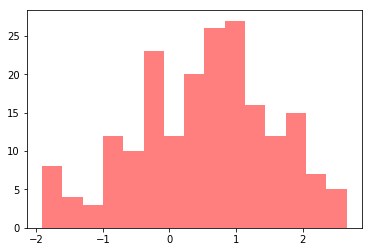

In [3]:
x1t = Xt[:,:1]
x2t = Xt[:,1:]
x1v = Xv[:,:1]
x2v = Xv[:,1:]
n, bins, patches = plt.hist(Yt[:,0], 15, facecolor='red', alpha=0.5)

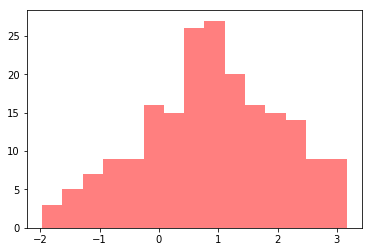

In [4]:
n, bins, patches = plt.hist(Yv[:,0], 15, facecolor='red', alpha=0.5)

Se observa en ambos casos que los datos parecen estar distribuidos conforme a una distribuciones normales. Esto es congruente con el planteamiento del problema, donde se establece que la función de salida fue contaminada con ruido gaussiano.

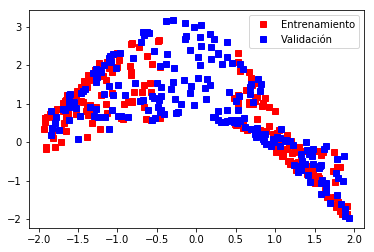

In [5]:
train_plot = plt.plot(x1t, Yt, 'rs', label= 'Entrenamiento')
valid_plot = plt.plot(x1v, Yv, 'bs', label= u'Validación')
plt.legend()
plt.show()

Nótese que en los datos de validación, no hay datos para el atributo $x_1$ cuando éste toma valores de entre -0.5 y 0.5.

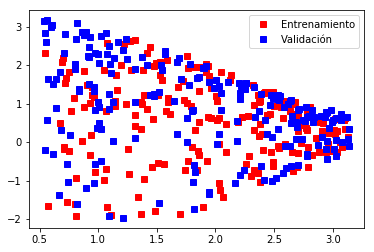

In [6]:
train_plot = plt.plot(x2t, Yt, 'rs', label= 'Entrenamiento')
valid_plot = plt.plot(x2v, Yv, 'bs', label= u'Validación')
plt.legend()
plt.show()

#### b) Regresión lineal

Para llevar a cabo la regresión lineal requerida por este problema, construimos nuestra matriz de diseño con base en la matriz de entradas $X_t$ y una columna de 1s, misma que servirá para representar y obtener al coeficiente $\theta_0$. Con estos datos, aplicamos la ecuación de forma cerrada $\theta = (X^{T}X)^{-1}X^{T}Y$ para obtener al vector de parámetros $\theta$.

In [7]:
# Design Matrix
ones_train = np.ones(x1t.shape[0])
phi_Xt = np.column_stack((ones_train, Xt))

# MLE / Least Squares
theta = np.dot(np.linalg.inv(np.dot(phi_Xt.T, phi_Xt)),np.dot(phi_Xt.T, Yt))
theta

array([[ 1.08332958],
       [-0.54618495],
       [-0.30062493]])

Los parámetros encontrados para el modelo planteado son:

- $\theta_1 = 1.0833$
- $\theta_2 = -0.5462$
- $\theta_3 = -0.3006$

Para obtener el error cuadrático medio (_MSE_) que este modelo recién entrenado arroja, basta con usar estos parámetros y nuestras matrices de entradas para crear un vector de predicciones $Y_h$, y comparar a éste contra nuestros vectores de etiquetas.

Primero evaluamos a nuestro modelo sobre nuestro conjunto de datos de entrenamiento, es decir, creamos a un vector de predicciones con base en $X_t$, y comparamos a estas predicciones contra el vector de etiquetas $Y_t$.

In [8]:
# Sum of the squared error calculation (SSE) over the training set
Yth = np.dot(phi_Xt, theta)
sse_training = np.square(Yt - Yth).sum()
mse_training = sse_training / Yt.size
mse_training

0.5896497098972882

Así pues, tenemos que $MSE_{Training} = 0.5896$.

Hacemos lo mismo para el conjunto de datos de validación, creando ahora a nuestro vector de predicciones con base en $X_v$, y comparando las predicciones contra el vector de etiquetas $Y_v$.

In [9]:
# Behavior of the validation set
ones_valid = np.ones(x1v.shape[0])
phi_Xv = np.column_stack((ones_valid, Xv))
Yvh = np.dot(phi_Xv, theta)
sse_validation = np.square(Yv - Yvh).sum()
mse_validation = sse_validation / Yv.size
mse_validation

0.8987307291283128

Así pues, tenemos que $SSE_{Validation} = 0.8987$. El _MSE_ para los datos de validación es superior al _MSE_ obtenido para los datos de entrenamiento. Esto es normal, pues el modelo se ajustó sobre los datos de entrenamiento (se espera que ellos den un desempeño superior).

#### c) Expansión de base polinomial / Regularización L2

Para llevar a cabo la expansión de base polinomial con norma L2, usaremos las mismas funciones empleadas en el problema 1. Dichas funciones ya fueron explicadas anteriormente.

In [10]:
def polynomial_expansion(X, degree):
    phi_X = X
    for i in range(degree - 1):
        powerX = np.power(X, i + 2)
        phi_X = np.column_stack((phi_X, powerX))
    return phi_X

In [11]:
# Performs a linear regression over the training set Xt/Yt using LS with L2
def regularized_lsq(Xt, Yt, lambda_val, degree):
        
    # Design matrix for a polynomial expansion of degree n
    phi_Xt = np.column_stack((np.ones(Xt.shape[0]), polynomial_expansion(Xt, degree)))

    # Create "ridge_matrix"
    XTX = np.dot(phi_Xt.T, phi_Xt)
    Id = np.identity(XTX.shape[0])
    ridge_matrix = lambda_val * Id

    # Regularizerd Least Squares
    theta = np.dot(np.linalg.inv(ridge_matrix + XTX), np.dot(phi_Xt.T, Yt))
    
    return theta

In [12]:
# Given the X test inputs, with their corresponding Y labels, and a vector of parameters theta, calculate
# the MSE
def mse_error(X, Y, theta):
    phi_X = np.column_stack((np.ones(X.shape[0]), X))
    Yh = np.dot(phi_X, theta)
    sse_training = np.square(Y - Yh).sum()
    mse_training = sse_training / Y.size
    return mse_training


In [13]:
# Performs several regularized_lq regressions over the sets, by using a different 
# set of basis functions (resulting from a polynomial expansion)
# Returns the MSE for the training and validations sets, and the resulting theta parameters
def regularized_lsq_errors(Xt, Yt, Xv, Yv, lambda_val, min_degree, max_degree):
    
    mse_training_values = []
    mse_validation_values = []
    
    for i in range(min_degree, max_degree + 1):
        theta = regularized_lsq(Xt, Yt, lambda_val, i)
        
        #Training set
        phi_Xt = polynomial_expansion(Xt, i)
        mse_training = mse_error(phi_Xt, Yt, theta)
        mse_training_values.append(mse_training)
        
        # Validation set
        phi_Xv = polynomial_expansion(Xv, i)
        mse_validation = mse_error(phi_Xv, Yv, theta)
        mse_validation_values.append(mse_validation)
    
    return mse_training_values, mse_validation_values

In [14]:
# Plot a comparison between the Training MSE and the Validation MSE, given the min and max
# degrees, and the lambda parameters
def plot_errors(Xt, Yt, Xv, Yv, lambda_val, min_degree, max_degree):
    mse_t, mse_v = regularized_lsq_errors(Xt, Yt, Xv, Yv, lambda_val, min_degree, max_degree)
    degree = np.arange(min_degree, max_degree + 1)
    train_plot = plt.plot(degree, mse_t, 'rs', label= 'Entrenamiento', linestyle='-')
    valid_plot = plt.plot(degree, mse_v, 'bs', label= u'Validación', linestyle='-')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Degree of the polynomial expansion')
    plt.ylabel('MSE')
    plt.title('MSE for lambda = ' + str(lambda_val))
    plt.show()

A continuación se muestran los desempeños de los modelos obtenidos, para expansiones polinomiales de grado 1 hasta 15, usando distintos parámetros de regularización.

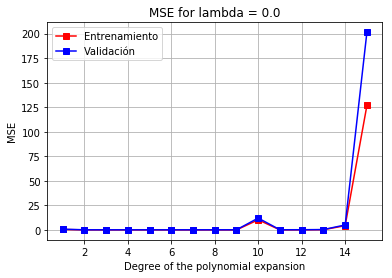

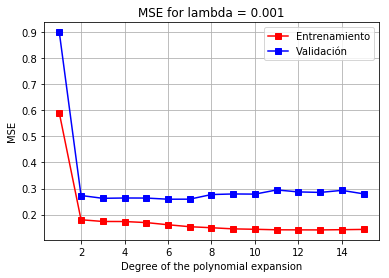

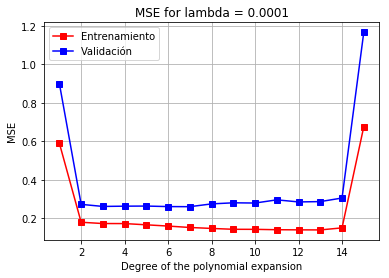

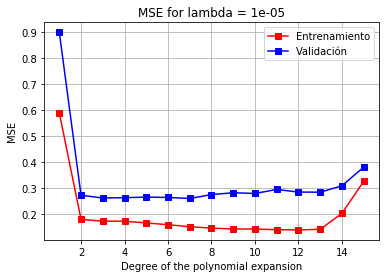

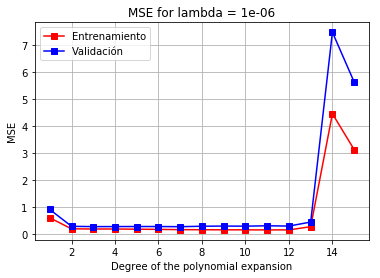

In [15]:
min_degree = 1
max_degree = 15
plot_errors(Xt, Yt, Xv, Yv, 0.0, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 0.001, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 0.0001, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 0.00001, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 0.000001, min_degree, max_degree)

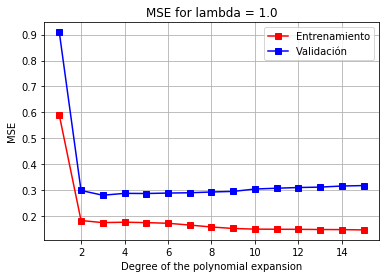

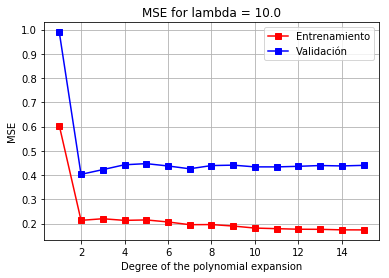

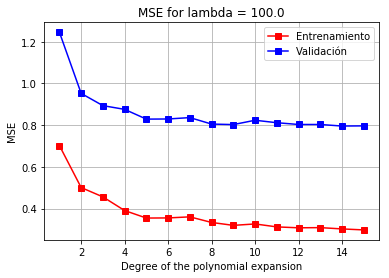

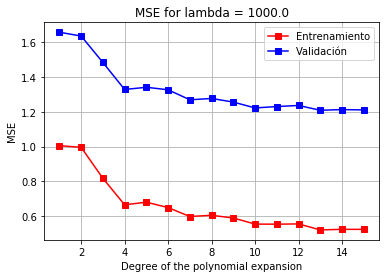

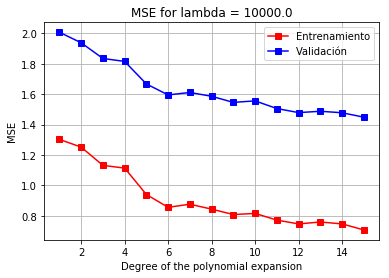

In [21]:
plot_errors(Xt, Yt, Xv, Yv, 1.0, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 10.0, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 100.0, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 1000.0, min_degree, max_degree)
plot_errors(Xt, Yt, Xv, Yv, 10000.0, min_degree, max_degree)

Observamos que, de las gráficas anteriores, los modelos con un parámetro de regularización muy pequeños mejoran mucho el desempeño del modelo con los datos de validación. En particular, observamos que es con $\lambda = 0.0001$ donde se observan los mejores resultados, para la mayoría de las expansiones polinomiales. Ya que usando este parámetro, las expansiones polinomiales tienen desempeños muy similares, por simplicidad, elegiremos al modelo que usa una expansión con grado igual a 2 como nuestro modelo a reportar.

In [19]:
chosen_lambda_value = 0.0001
chosen_degree = 2
theta = regularized_lsq(Xt, Yt, chosen_lambda_value, chosen_degree)
theta

array([[ 2.10067733],
       [-0.61608094],
       [-0.23677395],
       [-0.6165337 ],
       [-0.02981307]])

In [22]:
mse_training = mse_error(polynomial_expansion(Xt, chosen_degree), Yt, theta)
print mse_training
mse_validation = mse_error(polynomial_expansion(Xv, chosen_degree), Yv, theta)
print mse_validation

0.18034245429211979
0.27318148291685457


Con los parámetros obtenidos, los errores de generalización son pues **0.1803** y **0.2731**, para los datos de entrenamiento y datos de entrada, respectivamente.